In [3]:
DELTA_LAKE_TABLE = "loans.delta"

In [4]:
from deltalake import DeltaTable
dt = DeltaTable(DELTA_LAKE_TABLE)
dt.load_version(2)
print(dt.version())

2


In [6]:
df_clean = dt.to_pandas()
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

df_clean['term'] = label.fit_transform(df_clean['term'])
df_clean['grade'] = label.fit_transform(df_clean['grade'])
# df_clean['emp_length'] = label.fit_transform(df_clean['emp_length'])
df_clean['home_ownership'] = label.fit_transform(df_clean['home_ownership'])
df_clean['verification_status'] = label.fit_transform(df_clean['verification_status'])
df_clean['pymnt_plan'] = label.fit_transform(df_clean['pymnt_plan'])
df_clean['purpose'] = label.fit_transform(df_clean['purpose'])
df_clean['initial_list_status'] = label.fit_transform(df_clean['initial_list_status'])
df_clean['application_type'] = label.fit_transform(df_clean['application_type'])
df_clean['int_rate'] = label.fit_transform(df_clean['int_rate'])
df_clean['total_pymnt'] = label.fit_transform(df_clean['total_pymnt'])
df_clean['total_pymnt_inv'] = label.fit_transform(df_clean['total_pymnt_inv'])
df_clean['total_rec_prncp'] = label.fit_transform(df_clean['total_rec_prncp'])
df_clean['recoveries']= label.fit_transform(df_clean['recoveries'])
df_clean['collection_recovery_fee']= label.fit_transform(df_clean['collection_recovery_fee'])
df_clean['last_pymnt_amnt']= label.fit_transform(df_clean['last_pymnt_amnt'])

df_clean.head()

,loan_status,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,last_pymnt_amnt,int_rate,__index_level_0__
0,1,0,1,4,2,0,1,0,0,10282,11134,4190,0,0,5710,17,0
1,0,1,2,4,1,0,0,0,0,552,1003,461,953,159,3923,158,1
2,1,0,2,4,0,0,11,0,0,3891,4714,2527,0,0,16248,175,2
3,1,0,2,4,1,0,9,0,0,22667,23178,5573,0,0,11639,99,3
4,1,0,0,4,1,0,13,0,0,9627,10621,4190,0,0,5259,337,5


In [7]:
x = df_clean.drop(['loan_status'], axis=1)
y = df_clean['loan_status']

x.head()

,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,last_pymnt_amnt,int_rate,__index_level_0__
0,0,1,4,2,0,1,0,0,10282,11134,4190,0,0,5710,17,0
1,1,2,4,1,0,0,0,0,552,1003,461,953,159,3923,158,1
2,0,2,4,0,0,11,0,0,3891,4714,2527,0,0,16248,175,2
3,0,2,4,1,0,9,0,0,22667,23178,5573,0,0,11639,99,3
4,0,0,4,1,0,13,0,0,9627,10621,4190,0,0,5259,337,5


In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np 
import matplotlib.pyplot as plt


coltrans = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0,1,2,3,4,5,6,7,8])],        
    remainder = 'passthrough'                               
)

The training took 6.04 seconds.
98.56 %


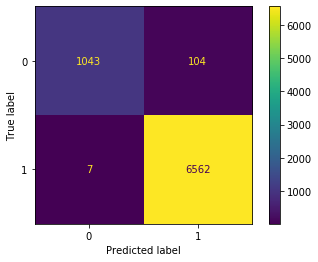

              precision    recall  f1-score   support

    Bad Loan       0.99      0.91      0.95      1147
   Good Loan       0.98      1.00      0.99      6569

    accuracy                           0.99      7716
   macro avg       0.99      0.95      0.97      7716
weighted avg       0.99      0.99      0.99      7716



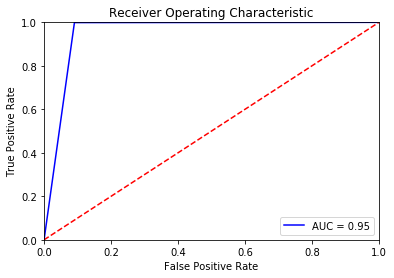

98.56 %


<Figure size 432x288 with 0 Axes>

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd

xtr, xts, ytr, yts = train_test_split(
    x,
    y,
    test_size = .2,
)

from sklearn.ensemble import RandomForestClassifier
import time

start = time.time()

model = RandomForestClassifier()
model.fit(xtr, ytr)

stop = time.time()
duration = stop-start
print('The training took {:.2f} seconds.'.format(duration))

print("Accuracy =>", round(model.score(xts, yts) * 100, 2), '%')
y_pred = model.predict(xts)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yts, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()


pd.crosstab(yts, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

from sklearn.metrics import classification_report

target_names = ['Bad Loan', 'Good Loan']
print(classification_report(yts, model.predict(xts), target_names=target_names))

import sklearn.metrics as metrics

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(xts)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(yts, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()